In [1]:
import torch
from evaluate import load
from transformers import (
	Seq2SeqTrainer,
	Seq2SeqTrainingArguments,
	TrOCRProcessor,
	VisionEncoderDecoderModel,
	default_data_collator,
)

from datasets import load_dataset
from taiwan_license_plate_recognition.helper import get_num_of_workers

In [2]:
num_workers: int = get_num_of_workers()

In [3]:
dataset = load_dataset("gagan3012/IAM", keep_in_memory=True, num_proc=num_workers).remove_columns(["label"])

In [4]:
dataset_split = dataset["train"].train_test_split(test_size=0.2, shuffle=True, seed=37710)

In [5]:
dataset["train"], dataset["validation"] = dataset_split["train"], dataset_split["test"]

In [6]:
dataset_split = dataset["train"].train_test_split(test_size=0.125, shuffle=True, seed=37710)

In [7]:
dataset["train"], dataset["test"] = dataset_split["train"], dataset_split["test"]

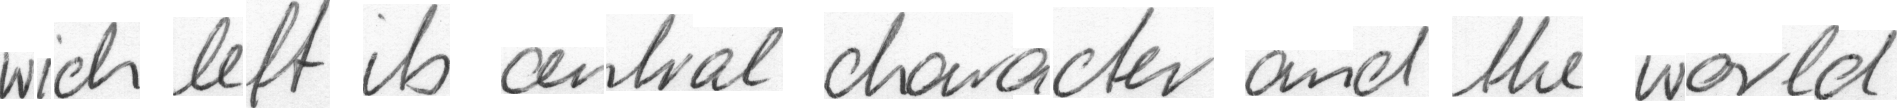

In [8]:
dataset["train"][0]["image"].convert("RGB")

In [9]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

In [17]:
base_model = VisionEncoderDecoderModel.from_pretrained(
	"microsoft/trocr-base-stage1", attn_implementation="eager", torch_dtype=torch.bfloat16
)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
# set special tokens used for creating the decoder_input_ids from the labels
base_model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
base_model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
base_model.config.vocab_size = base_model.config.decoder.vocab_size

# set beam search parameters
base_model.config.eos_token_id = processor.tokenizer.sep_token_id
base_model.config.max_length = 64
base_model.config.early_stopping = True
base_model.config.no_repeat_ngram_size = 3
base_model.config.length_penalty = 2.0
base_model.config.num_beams = 4

In [11]:
dataset = dataset.map(
	lambda sample: {
		"data": processor.image_processor(sample.convert("RGB"), return_tensors="pt").pixel_values
	},
	input_columns=["image"],
	remove_columns=["image"],
	batched=False,
	num_proc=num_workers,
)

Map (num_proc=20):   0%|          | 0/7940 [00:00<?, ? examples/s]

TypeError: 'PngImageFile' object is not iterable

In [10]:
dataset = dataset.map(
	lambda sample: {"label": processor.tokenizer(sample, padding="max_length").input_ids},
	input_columns=["text"],
	remove_columns=["text"],
	batched=False,
	num_proc=num_workers,
)

ERROR! Session/line number was not unique in database. History logging moved to new session 5


Map (num_proc=20):   0%|          | 0/7940 [00:00<?, ? examples/s]

Process ForkPoolWorker-48:
Process ForkPoolWorker-41:
Process ForkPoolWorker-47:
Process ForkPoolWorker-50:
Process ForkPoolWorker-38:
Process ForkPoolWorker-45:
Process ForkPoolWorker-39:
Process ForkPoolWorker-51:
Process ForkPoolWorker-33:
Process ForkPoolWorker-52:
Process ForkPoolWorker-37:
Process ForkPoolWorker-46:
Process ForkPoolWorker-36:
Process ForkPoolWorker-43:
Process ForkPoolWorker-40:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-34:
Process ForkPoolWorker-44:
Process ForkPoolWorker-35:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-42:
  File "/home/hermeschen/Repo/taiwan-license-plate-recognition/.venv/lib/python3.12/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
Traceback

KeyboardInterrupt: 

  File "/home/hermeschen/Repo/taiwan-license-plate-recognition/.venv/lib/python3.12/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


In [ ]:
trainer_arguments = Seq2SeqTrainingArguments(
	predict_with_generate=True,
	evaluation_strategy="steps",
	per_device_train_batch_size=8,
	per_device_eval_batch_size=8,
	fp16=True,
	output_dir="../",
	logging_steps=2,
	save_steps=1000,
	eval_steps=200,
)

In [ ]:
metrics = load("cer", num_process=num_workers, keep_in_memory=True)

In [ ]:
def compute_metrics(pred):
	labels_ids = pred.label_ids
	pred_ids = pred.predictions

	pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
	labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
	label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

	score = metrics.compute(predictions=pred_str, references=label_str)

	return {"cer": score}

In [ ]:
trainer = Seq2SeqTrainer(
	model=base_model,
	tokenizer=processor.feature_extractor,
	args=trainer_arguments,
	compute_metrics=compute_metrics,
	train_dataset=dataset["train"],
	eval_dataset=dataset["validation"],
	data_collator=default_data_collator,
)

In [ ]:
trainer.train()